In [228]:
from urllib.request import urlopen
from xmltodict import parse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from keras.optimizers import Adam, Adamax, RMSprop, SGD

import keras.backend as K

In [229]:
def QueryECB(series):
    raw1 = urlopen("https://sdw-wsrest.ecb.europa.eu/service/data/EXR/" + series + ".SP00.A")
    raw2 = raw1.read().decode('utf8')
    raw3 = parse(raw2)
    raw4 = raw3['message:GenericData']['message:DataSet']['generic:Series']['generic:Obs']
    res = {x['generic:ObsDimension']['@value']: 
           float(x['generic:ObsValue']['@value'])
           for x in raw4}
    return res

In [230]:
cad = QueryECB("D.CAD.EUR")
usd = QueryECB("D.USD.EUR")

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [179]:
df = pd.DataFrame({'CAD/EUR': [x for x in cad.values()], 
                   'USD/EUR': [x for x in usd.values()]}, 
                  [x for x in usd.keys()])
df.head(10)

,CAD/EUR,USD/EUR
1999-01-04,1.8004,1.1789
1999-01-05,1.7965,1.1790
1999-01-06,1.7711,1.1743
1999-01-07,1.7602,1.1632
1999-01-08,1.7643,1.1659
1999-01-11,1.7463,1.1569
1999-01-12,1.7392,1.1520
1999-01-13,1.8123,1.1744
1999-01-14,1.7707,1.1653
1999-01-15,1.7797,1.1626


In [182]:
df.iloc[:,1] = df.iloc[:,1].shift(1)

In [217]:
df = df.dropna()

sc = Normalizer()
df_sc = sc.fit_transform(df)

train = df_sc[:4500,]
test = df_sc[4500:4860,]

x_train = train[:,0]
y_train = train[:,1]
x_test = test[:,0]
y_test = test[:,1]

In [218]:
K.clear_session()

model = Sequential()

model.add(Dense(30, input_shape=(1,), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dropout(0.05))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(1, activation='relu'))

model.compile(optimizer=Adamax(lr=0.004), loss='mean_absolute_error')
model.fit(x_train, y_train, batch_size=5, epochs=20, verbose=1)

Epoch 1/20
4500/4500 [==============================] - 1s 187us/step - loss: 0.1181
Epoch 2/20
4500/4500 [==============================] - 1s 158us/step - loss: 0.0391
Epoch 3/20
4500/4500 [==============================] - 1s 196us/step - loss: 0.0197
Epoch 4/20
4500/4500 [==============================] - 1s 154us/step - loss: 0.0141
Epoch 5/20
4500/4500 [==============================] - 1s 157us/step - loss: 0.0118
Epoch 6/20
4500/4500 [==============================] - 1s 165us/step - loss: 0.0093
Epoch 7/20
4500/4500 [==============================] - 1s 159us/step - loss: 0.0085
Epoch 8/20
4500/4500 [==============================] - 1s 162us/step - loss: 0.0079
Epoch 9/20
4500/4500 [==============================] - 1s 172us/step - loss: 0.0064
Epoch 10/20
4500/4500 [==============================] - 1s 186us/step - loss: 0.0057
Epoch 11/20
4500/4500 [==============================] - 1s 162us/step - loss: 0.0055
Epoch 12/20
4500/4500 [==============================] - 1s 156

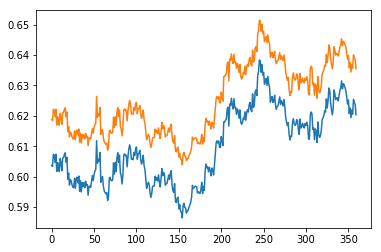

In [219]:
y_pred = model.predict(x_test)

plt.plot(y_test)
plt.plot(y_pred)

In [226]:
K.clear_session()
model = Sequential()

model.add(Dense(80, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(LSTM(20,
              return_sequences=True,
              activation='tanh'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error')
model.fit(x_train.reshape(50,90,1), y_train.reshape(50,90,1), batch_size=5, epochs=10, verbose=1)

Epoch 1/10
50/50 [==============================] - 1s 18ms/step - loss: 0.4065
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4065
Epoch 3/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4065
Epoch 4/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4065
Epoch 5/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4065
Epoch 6/10
50/50 [==============================] - 0s 8ms/step - loss: 0.4064
Epoch 7/10
50/50 [==============================] - 0s 8ms/step - loss: 0.4063
Epoch 8/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4044
Epoch 9/10
50/50 [==============================] - 0s 7ms/step - loss: 0.1099
Epoch 10/10
50/50 [==============================] - 0s 8ms/step - loss: 0.0107


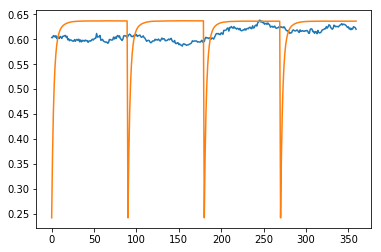

In [227]:
y_pred = model.predict(x_test.reshape(4,90,1))

plt.plot(y_test)
plt.plot(y_pred.reshape(360))

In [108]:
df.shape

(5110, 2)